## Install Required Libraries

In [ ]:
!pip install -q ucimlrepo
!pip install -q optuna
!pip install -q shap==0.44.1
!pip install -q lime
#!pip install -q numpy==1.26.4



## Import Required Libraries  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler

import optuna
from sklearn.pipeline import Pipeline

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, f1_score, confusion_matrix)

# Classifiers
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import (RandomForestClassifier,
                             ExtraTreesClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import pickle
from sklearn.inspection import permutation_importance

import lime
import lime.lime_tabular
import shap

import warnings
warnings.filterwarnings('ignore')
import random
import os
# Ensure reproducibility for joblib-based models (e.g., scikit-learn)
os.environ["PYTHONHASHSEED"] = "145"





## Download Dermatology Dataset

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
dermatology = fetch_ucirepo(id=33)

# data (as pandas dataframes)
X = dermatology.data.features
y = dermatology.data.targets


## Preparing Data for Modeling

- Train-Test Split
We must perform a train-test split before data preprocessing to avoid **data leakage** for standardization, imputation and so forth!

In [ ]:
#Splitting the set


# Split the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shape of the splits
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (292, 34)
Testing set shape: (74, 34)


- Finding Data Points with Null Entry

In [ ]:
X_train[X_train['age'].isnull()]

,erythema,scaling,definite-borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral-mucosal involvement,knee elbow involvement,scalp involvement,...,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of the basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear infiltrate,band-like infiltrate,age
263,1,1,1,3,0,0,0,0,0,0,...,0,0,0,3,0,0,0,2,0,NaN
34,2,1,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
36,2,1,2,3,2,3,0,2,0,0,...,1,0,2,0,2,0,0,0,3,NaN
265,1,1,0,3,0,0,0,0,0,0,...,0,0,0,2,0,0,0,3,0,NaN
33,2,2,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,NaN


In [ ]:
X_test[X_test['age'].isnull()]

,erythema,scaling,definite-borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral-mucosal involvement,knee elbow involvement,scalp involvement,...,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of the basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear infiltrate,band-like infiltrate,age
35,2,2,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
264,1,1,0,2,0,0,0,0,1,0,...,0,0,0,2,0,0,0,3,0,NaN
262,2,1,0,2,0,0,0,0,0,0,...,0,0,0,2,0,0,0,3,0,NaN


## Imputation

The age attribute has missing values. In this part we handle the missing values by comparing different imputation methods: median, mean and KNN imputations. The original study used median imputation, but we would like to explore other methods too.

In [ ]:
# Median Imputation (used in original study)
median_imputer = SimpleImputer(strategy='median')
X_median = pd.DataFrame(median_imputer.fit_transform(X_train), columns=X.columns)

# Mean Imputation
mean_imputer = SimpleImputer(strategy='mean')
X_mean = pd.DataFrame(mean_imputer.fit_transform(X_train), columns=X.columns)

# KNN Imputation (k=5)
knn_imputer = KNNImputer(n_neighbors=5)
X_knn = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X.columns)

# Extract imputed age values
original_age = X['age'].copy()
imputed_age = {
    'Median': X_median['age'],
    'Mean': X_mean['age'],
    'KNN': X_knn['age'],
}

# Compare summary statistics
stats = pd.DataFrame({
    method: imputed_age[method].describe()[['mean', 'std', 'min', '50%', 'max']]
    for method in imputed_age
})
print(stats.T)


             mean        std  min   50%   max
Median  36.688356  15.554653  0.0  36.0  75.0
Mean    36.700348  15.554386  0.0  36.0  75.0
KNN     36.680822  15.591064  0.0  36.0  75.0


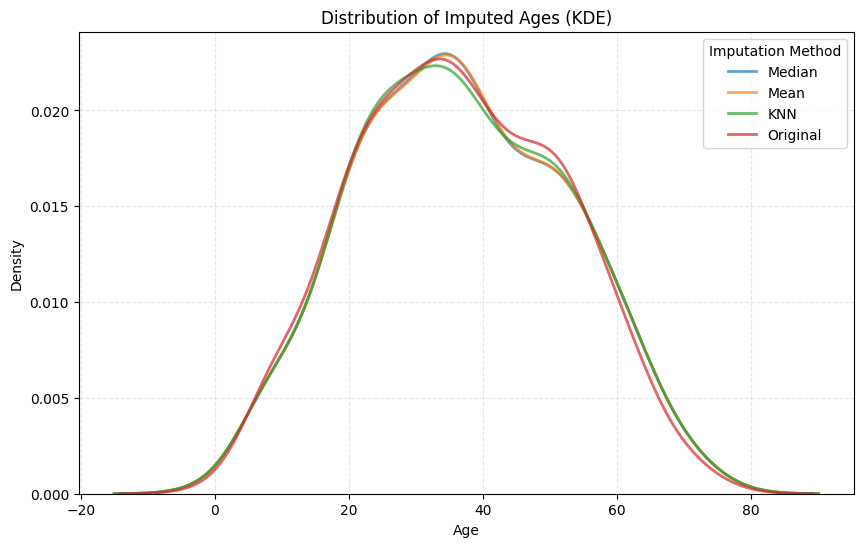

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 6))
for method, ages in imputed_age.items():
    sns.kdeplot(ages, label=method, alpha=0.7, linewidth=2)
sns.kdeplot(original_age, label='Original', alpha=0.7, linewidth=2)
plt.title("Distribution of Imputed Ages (KDE)")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend(title="Imputation Method")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()
plt.savefig('imputed_ages.png')

In general, Median Imputation preserves original distribution but ignores relationship with other features. MEan Imputation smooths out variability, and may distort the original distribution, KNN Imputation leverages feature correlations but is sensitive to outliers.

In this case, the probability density distribution of the 'age' variable shows significant overlap between values. To preserve the original age distribution, we chose the simplest imputation method: using the median. This approach ensures that the age variable remains consistent with the dataset's overall structure and avoids introducing bias.

- apply median imputer

In [ ]:
median_imputer = SimpleImputer(strategy="median")
median_imputer.fit(X_train[["age"]])

# Transform both train and test sets using the SAME imputer
X_train["age"] = median_imputer.transform(X_train[["age"]])
X_test["age"] = median_imputer.transform(X_test[["age"]])


In [ ]:
X_train[X_train['age'].isnull()]

,erythema,scaling,definite-borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral-mucosal involvement,knee elbow involvement,scalp involvement,...,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of the basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear infiltrate,band-like infiltrate,age


In [ ]:
X_test[X_test['age'].isnull()]

,erythema,scaling,definite-borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral-mucosal involvement,knee elbow involvement,scalp involvement,...,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of the basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear infiltrate,band-like infiltrate,age


 ## Training/cross validation pipeline
 - Baysian Optimization for Hyperparameter Tuning (Optuna)

This code snippet focuses on training and evaluating several machine learning models to find the best one for the dermatology dataset.

In [ ]:
y_train = y_train['class'] - 1
y_test = y_test['class'] - 1

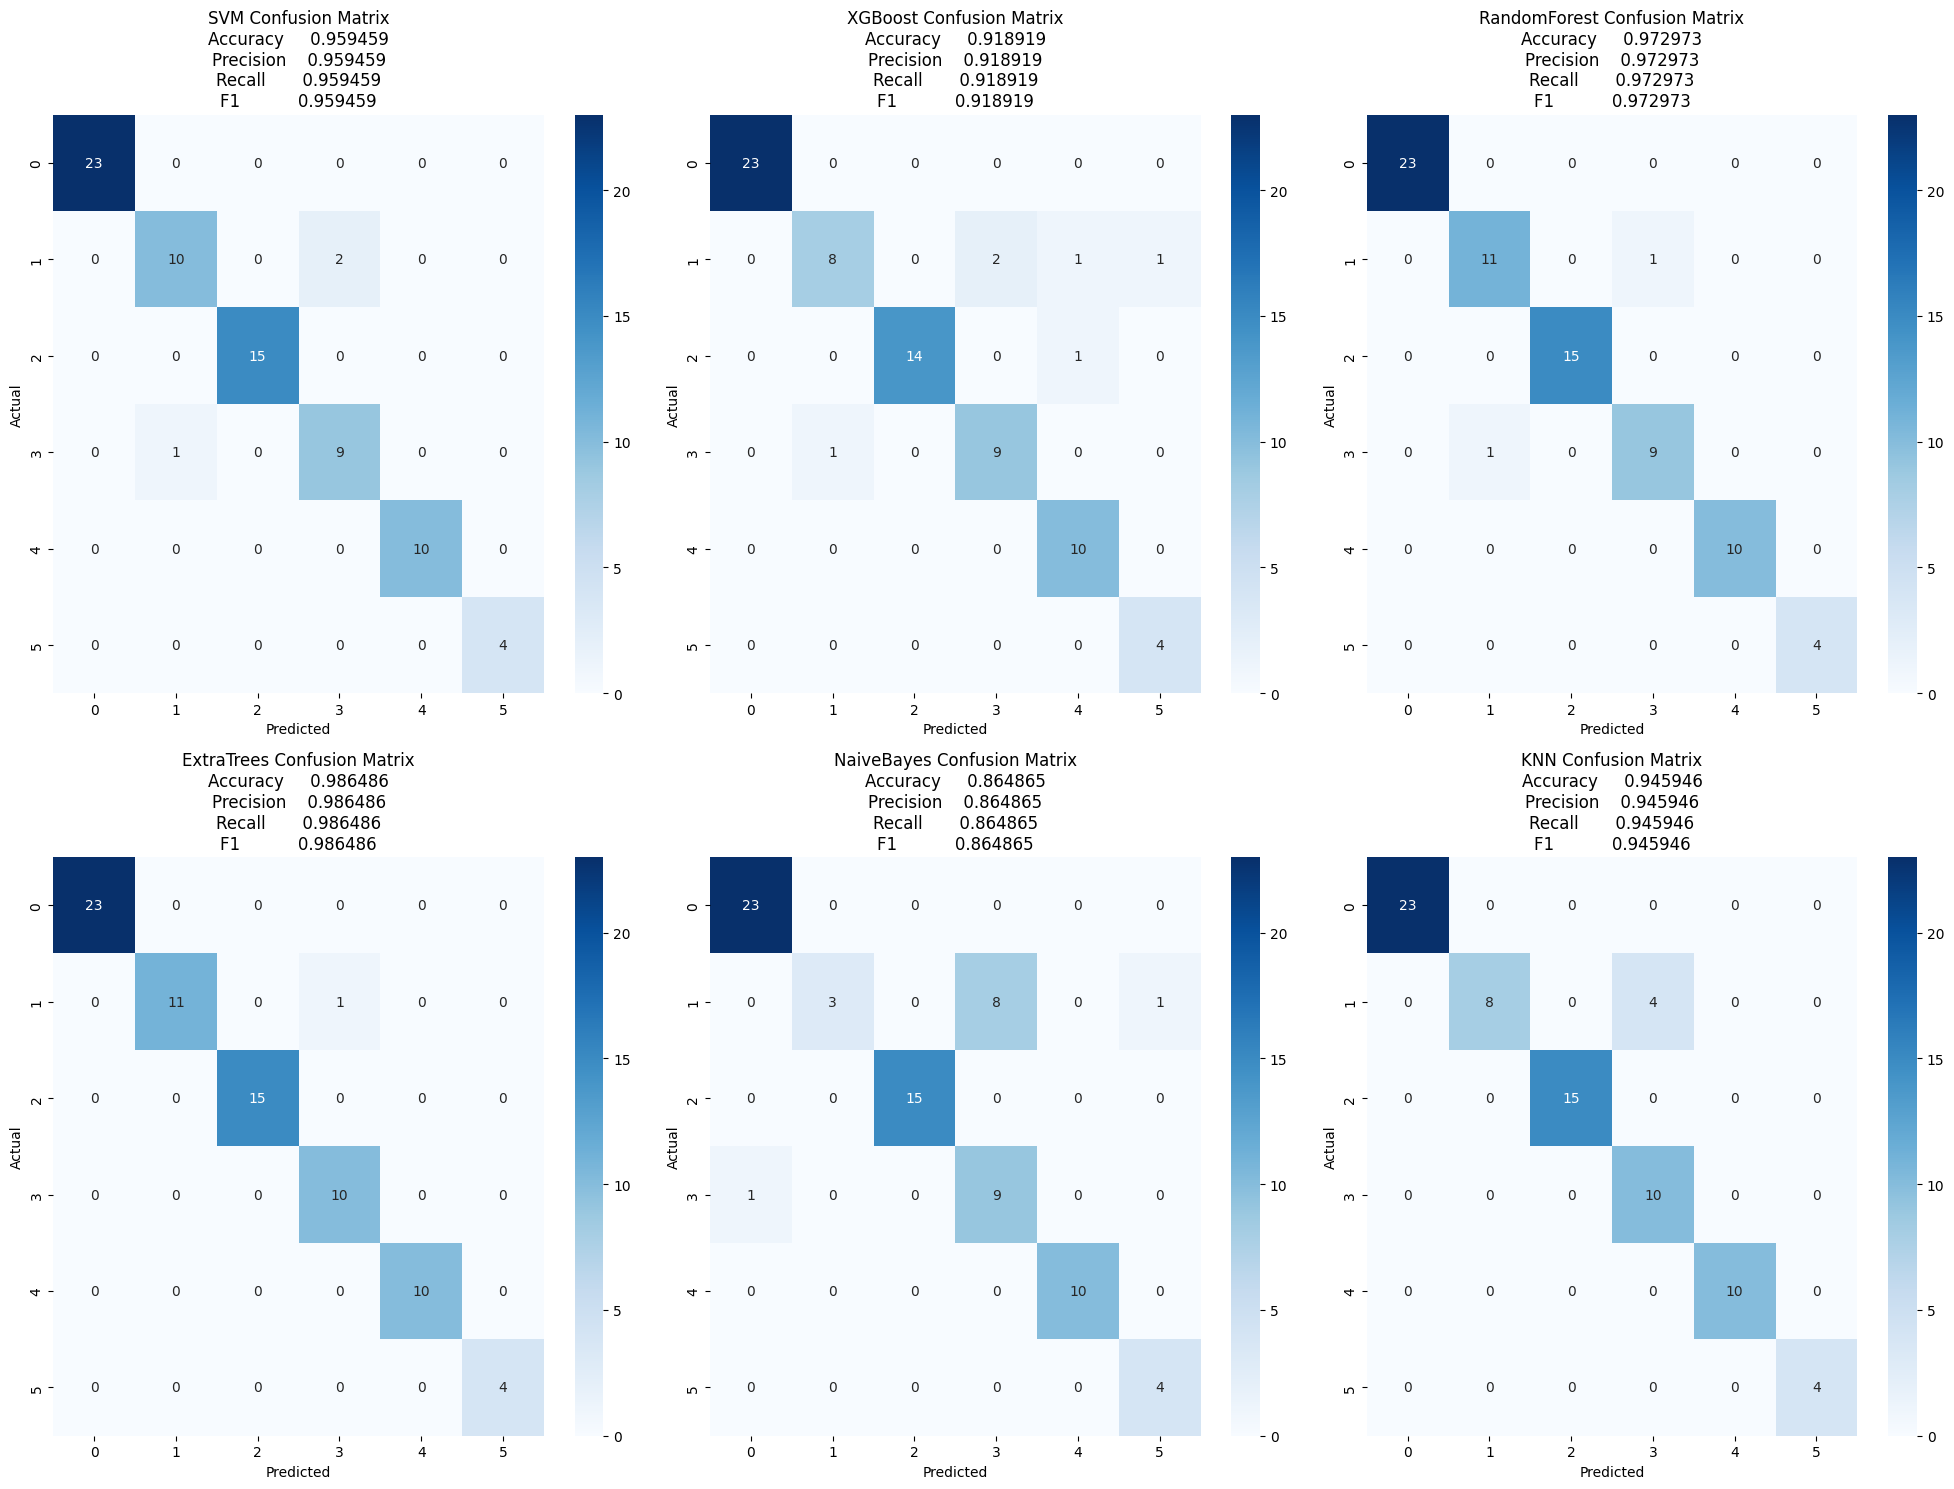

Best Parameters:

SVM:
{'C': 0.03785351365100448, 'kernel': 'linear', 'gamma': 0.15992305836738005}

XGBoost:
{'learning_rate': 0.010630085267930736, 'max_depth': 6, 'subsample': 0.9522872350266538, 'colsample_bytree': 0.7536018702282989, 'scale_pos_weight': 2.2808988764044944}

RandomForest:
{'n_estimators': 230, 'max_depth': 7, 'min_samples_split': 7}

ExtraTrees:
{'n_estimators': 332, 'max_depth': 4, 'min_samples_split': 7}

NaiveBayes:
No hyperparameters

KNN:
{'n_neighbors': 6, 'p': 1}

Performance Comparison:
              Accuracy  Precision    Recall        F1
Model                                                
ExtraTrees    0.986486   0.986486  0.986486  0.986486
RandomForest  0.972973   0.972973  0.972973  0.972973
SVM           0.959459   0.959459  0.959459  0.959459
KNN           0.945946   0.945946  0.945946  0.945946
XGBoost       0.918919   0.918919  0.918919  0.918919
NaiveBayes    0.864865   0.864865  0.864865  0.864865


In [ ]:

# Initialize results storage
results = []
best_params = {}
confusion_matrices = {}

# Set seed for Python's built-in random module
random.seed(145)

# Set seed for NumPy
np.random.seed(145)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))



# Define model configurations
models = {
    'SVM': {
        'model': SVC(decision_function_shape='ovr', max_iter=10000, class_weight=class_weights_dict),
        'params': {
            'C': (1e-3, 1e3, 'log'),
            'kernel': ['linear', 'rbf'],
            'gamma': (1e-4, 1, 'log')
        }
    },
    'XGBoost': {
        'model': XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train))),
        'params': {
            'learning_rate': (0.01, 1.0, 'log'),
            'max_depth': (3, 10, 'int'),
            'subsample': (0.5, 1.0, 'float'),
            'colsample_bytree': (0.5, 1.0, 'float'),
            'scale_pos_weight': [len(y_train[y_train != i]) / len(y_train[y_train == i]) for i in np.unique(y_train)]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(class_weight=class_weights_dict),
        'params': {
            'n_estimators': (100, 500, 'int'),
            'max_depth': (3, 15, 'int'),
            'min_samples_split': (2, 10, 'int')
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesClassifier(class_weight=class_weights_dict),
        'params': {
            'n_estimators': (100, 500, 'int'),
            'max_depth': (3, 15, 'int'),
            'min_samples_split': (2, 10, 'int')
        }
    },
    'NaiveBayes': {
        'model': GaussianNB(),
        'params': {}
    },
    'KNN': {
        'model': KNeighborsClassifier(weights='distance'),  # Use distance weighting
        'params': {
            'n_neighbors': (3, 15, 'int'),
            'p': [1, 2]  # 1=Manhattan, 2=Euclidean
        }
    }
}

#Hyperparameter Optimization with Optuna
def objective(trial, model_name):
    config = models[model_name]
    model = config['model'].set_params(**config['model'].get_params())  # Reset model

    params = {}
    for param, spec in config['params'].items():
        if isinstance(spec, tuple):
            low, high, param_type = spec
            if param_type == 'log':
                params[param] = trial.suggest_float(param, low, high, log=True)
            elif param_type == 'int':
                params[param] = trial.suggest_int(param, low, high)
            elif param_type == 'float':
                params[param] = trial.suggest_float(param, low, high)
        elif isinstance(spec, list):
            params[param] = trial.suggest_categorical(param, spec)

    # Create pipeline
    if model_name in ['SVM', 'KNN']:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model.set_params(**params))
        ])
    else:
        pipeline = Pipeline([
            ('model', model.set_params(**params))
        ])

    # Cross-validation with error handling
    try:
        score = cross_val_score(
            pipeline, X_train, y_train,
            cv=5, scoring='accuracy', n_jobs=-1,
            error_score='raise'
        ).mean()
    except Exception as e:
        print(f"Error in {model_name}: {str(e)}")
        score = -1  # Return invalid score for pruning

    return score


optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optimization and evaluation loop
for model_name in models.keys():
    if model_name == 'NaiveBayes':
        # Create proper pipeline for NaiveBayes
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', GaussianNB())
        ])
        pipeline.fit(X_train, y_train)
        best_params[model_name] = "No hyperparameters"
    else:
        sampler = optuna.samplers.TPESampler(seed=145)
        study = optuna.create_study(direction='maximize', sampler=sampler)
        study.optimize(
            lambda trial: objective(trial, model_name),
            n_trials=50,
            n_jobs=-1
        )
        best_params[model_name] = study.best_params

        ## Create proper pipeline with best params
        if model_name in ['SVM', 'KNN']:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                 ('model', models[model_name]['model'].set_params(**study.best_params))
            ])
        else:
            pipeline = Pipeline([
                ('model', models[model_name]['model'].set_params(**study.best_params))
            ])

        pipeline.fit(X_train, y_train)

    # Evaluation
    y_pred = pipeline.predict(X_test)

    # Store metrics
    results.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='micro'),
        'Recall': recall_score(y_test, y_pred, average='micro'),
        'F1': f1_score(y_test, y_pred, average='micro')
    })

    # Store confusion matrix
    confusion_matrices[model_name] = confusion_matrix(y_test, y_pred)

# Rest of visualization code remains the same
# Results DataFrame
results_df = pd.DataFrame(results).set_index('Model')

# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
for (name, cm), ax in zip(confusion_matrices.items(), axes.flatten()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{name} Confusion Matrix\n{results_df.loc[name].to_string()}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrices.png')

plt.show()

# Print best parameters
print("Best Parameters:")
for model, params in best_params.items():
    print(f"\n{model}:")
    print(params if isinstance(params, dict) else "No hyperparameters")

# Display results
print("\nPerformance Comparison:")
print(results_df.sort_values('F1', ascending=False))

## Cross-validation Interpretation

Our results show that the **Extra Trees Classifier** performed the best, achieving an **accuracy, precision, recall, and F1-score of 0.986486**. This suggests that it consistently makes correct predictions across all classes, outperforming models like KNN, Naïve Bayes, and XGBoost. The **SVM and Random Forest classifiers** also performed well, but Extra Trees had the best overall performance. Looking at class 6 (the rare class), Extra Trees successfully identified **4 instances correctly** with no misclassifications, demonstrating its strength in handling imbalanced data. This suggests that the model benefits from its **ensemble nature and ability to reduce overfitting**, making it the most reliable choice for this dataset.



## Feature Importance

<Figure size 2000x1500 with 0 Axes>

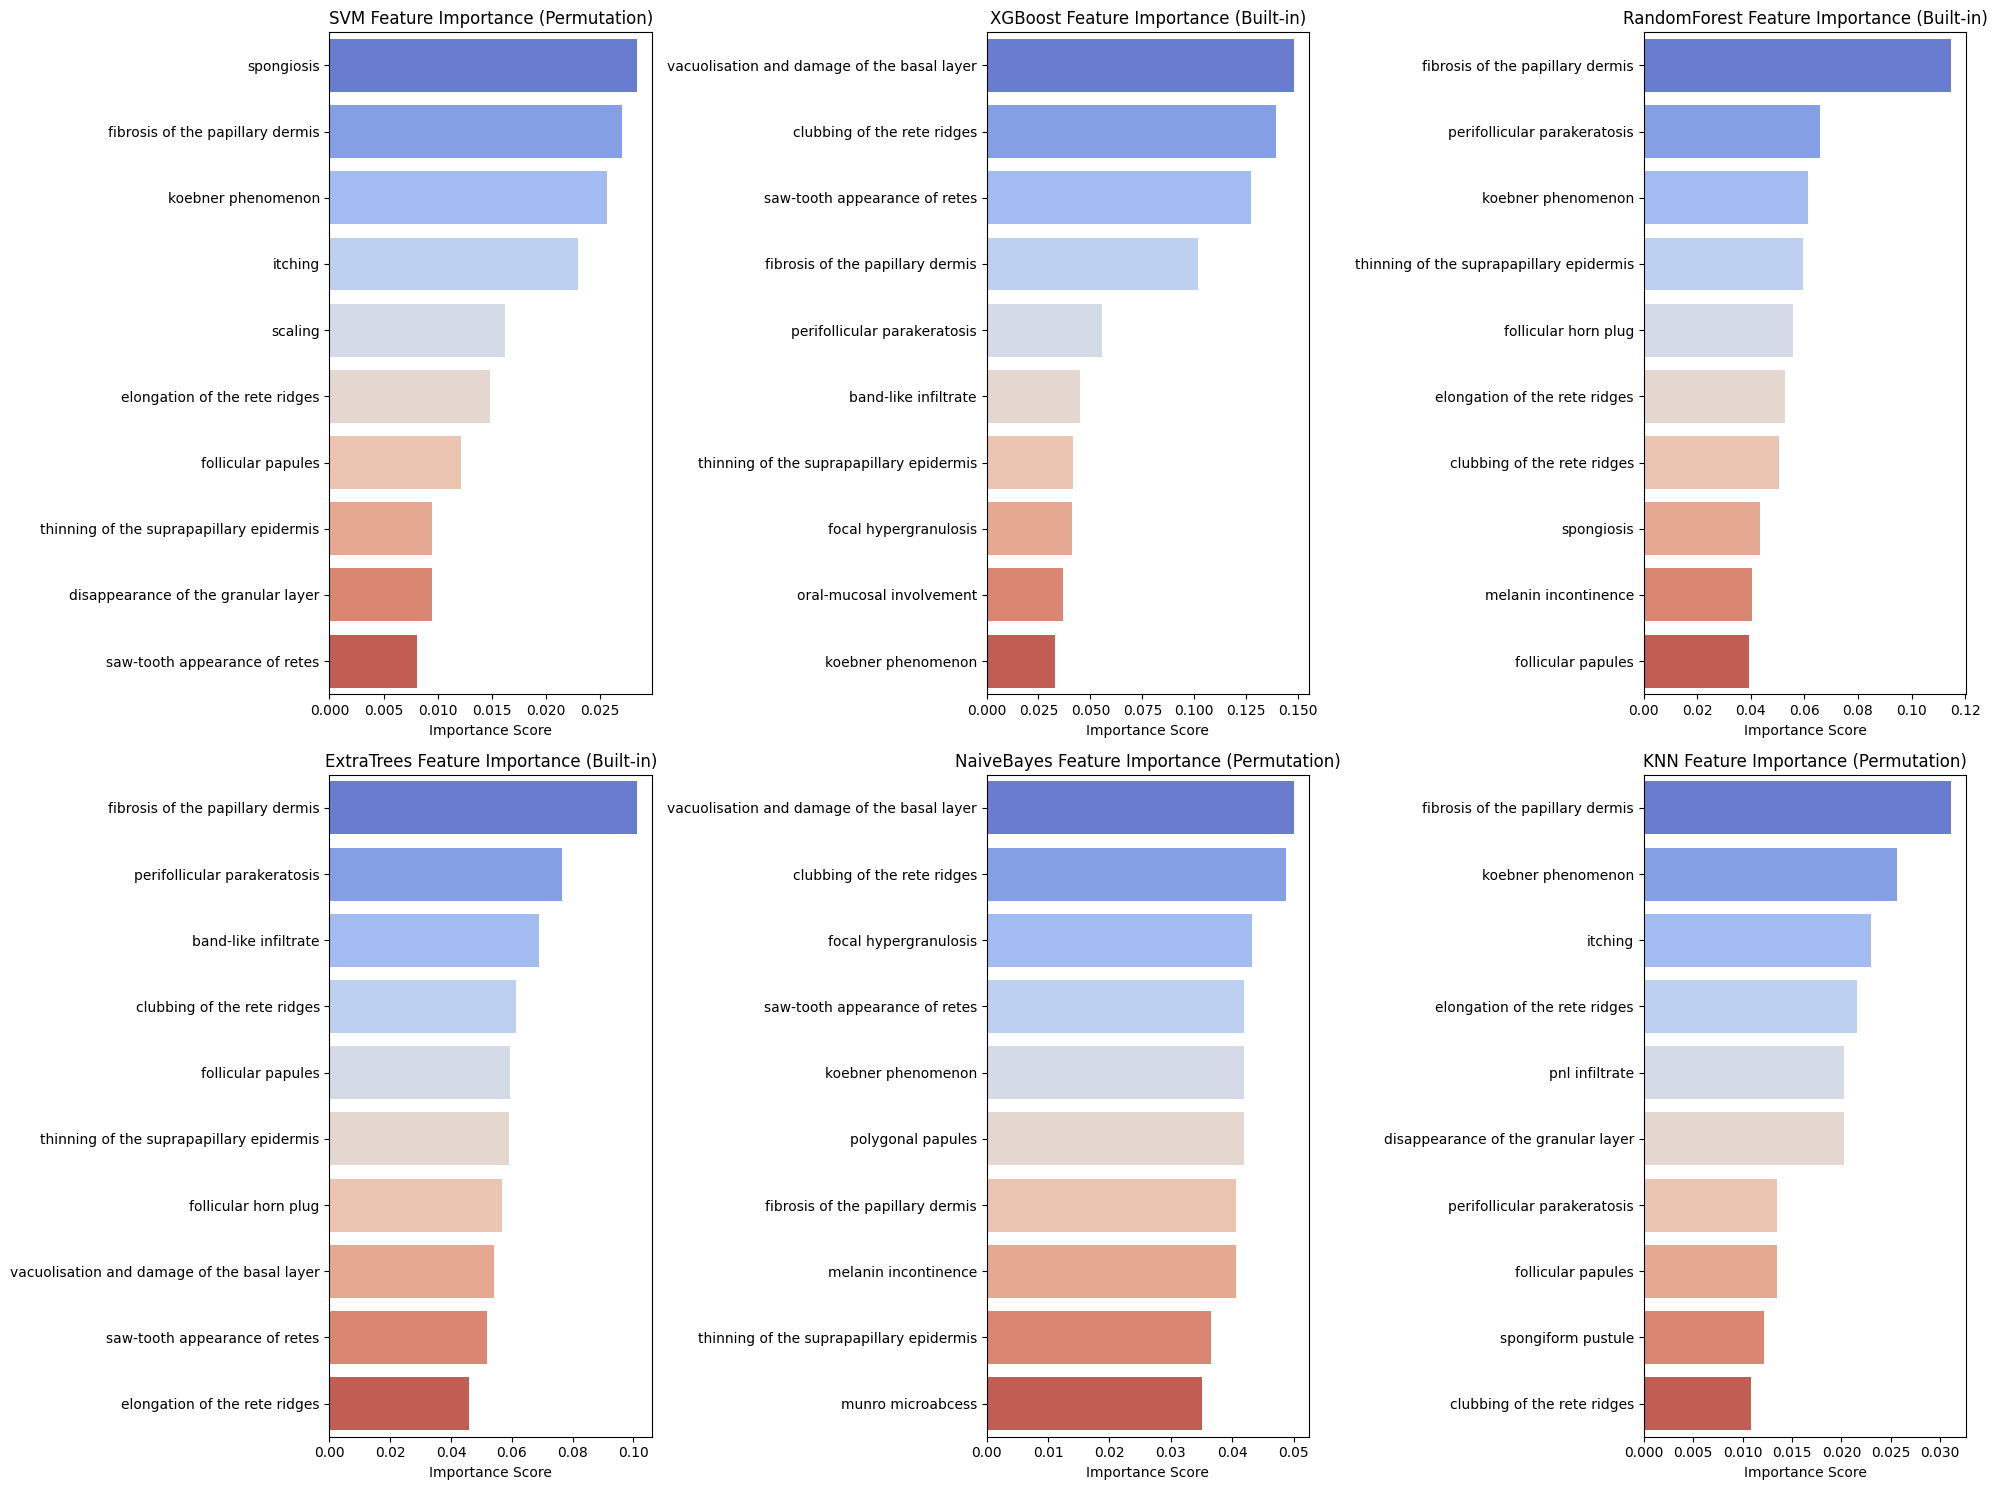

<Figure size 640x480 with 0 Axes>

In [ ]:


# Get feature names (assuming X is a DataFrame)
feature_names = X.columns.tolist()

# Create subplots for feature importance visualization
plt.figure(figsize=(20, 15))

# Corrected pipeline initialization and fitting
best_pipelines = {}

for model_name in models.keys():
    if model_name == 'NaiveBayes':
        # Create and fit Naive Bayes pipeline
        nb_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', GaussianNB())
        ])
        nb_pipeline.fit(X_train, y_train)
        best_pipelines[model_name] = nb_pipeline
    else:
        # Rebuild pipeline with best params for other models
        if model_name in ['SVM', 'KNN']:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', models[model_name]['model'].set_params(**best_params[model_name]))
            ])
        else:
            pipeline = Pipeline([
                ('model', models[model_name]['model'].set_params(**best_params[model_name]))
            ])

        pipeline.fit(X_train, y_train)
        best_pipelines[model_name] = pipeline

# Now run feature importance plotting
plt.figure(figsize=(20, 15))

# Plot feature importance for each model
for idx, (model_name, pipeline) in enumerate(best_pipelines.items(), 1):
    plt.subplot(2, 3, idx)

    try:
        # For tree-based models
        if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
            importances = pipeline.named_steps['model'].feature_importances_
            importance_type = "Built-in"
        # For other models, use permutation importance
        else:
            result = permutation_importance(
                pipeline, X_test, y_test,
                n_repeats=10,
                random_state=42,
                n_jobs=-1
            )
            importances = result.importances_mean
            importance_type = "Permutation"

        # Create importance DataFrame
        feat_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False).head(10)

        # Plot
        sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='coolwarm')
        plt.title(f'{model_name} Feature Importance ({importance_type})')
        plt.xlabel('Importance Score')
        plt.ylabel('')

    except Exception as e:
        print(f"Feature importance failed for {model_name}: {str(e)}")
        plt.title(f"{model_name}\nFeature Importance Not Available")
        plt.axis('off')

plt.tight_layout()
plt.show()
plt.savefig('feature_importance.png')

The figure illustrates feature importance rankings derived from several classifiers (SVM, XGBoost, Random Forest, ExtraTrees, Naive Bayes, and KNN). Across the models, certain features consistently appear as highly important, such as "fibrosis of the papillary dermis," "vacuolisation and damage of the basal layer," and "clubbing of the rete ridges." This consistency suggests these features are critical for distinguishing dermatological conditions regardless of the classifier used. For example, "fibrosis of the papillary dermis" is ranked highly by SVM, Random Forest, and ExtraTrees, while "vacuolisation and damage of the basal layer" is particularly emphasized by XGBoost and Naive Bayes.

Moreover, there are variations in feature importance across models. For instance, SVM highlights "spongiform pustule" and "spongiosis," whereas XGBoost and Naive Bayes prioritize structural changes like "saw-tooth appearance of rete ridges" or "melanin incontinence." These differences reflect how each algorithm processes data and identifies patterns. Additionally, permutation-based methods (e.g., SVM, Naive Bayes, KNN) focus on different features compared to built-in importance measures (e.g., XGBoost, Random Forest). This highlights the need for careful selection of feature importance techniques depending on the model and interpretability goals.

## LIME Interpretation

<Figure size 2000x1000 with 0 Axes>

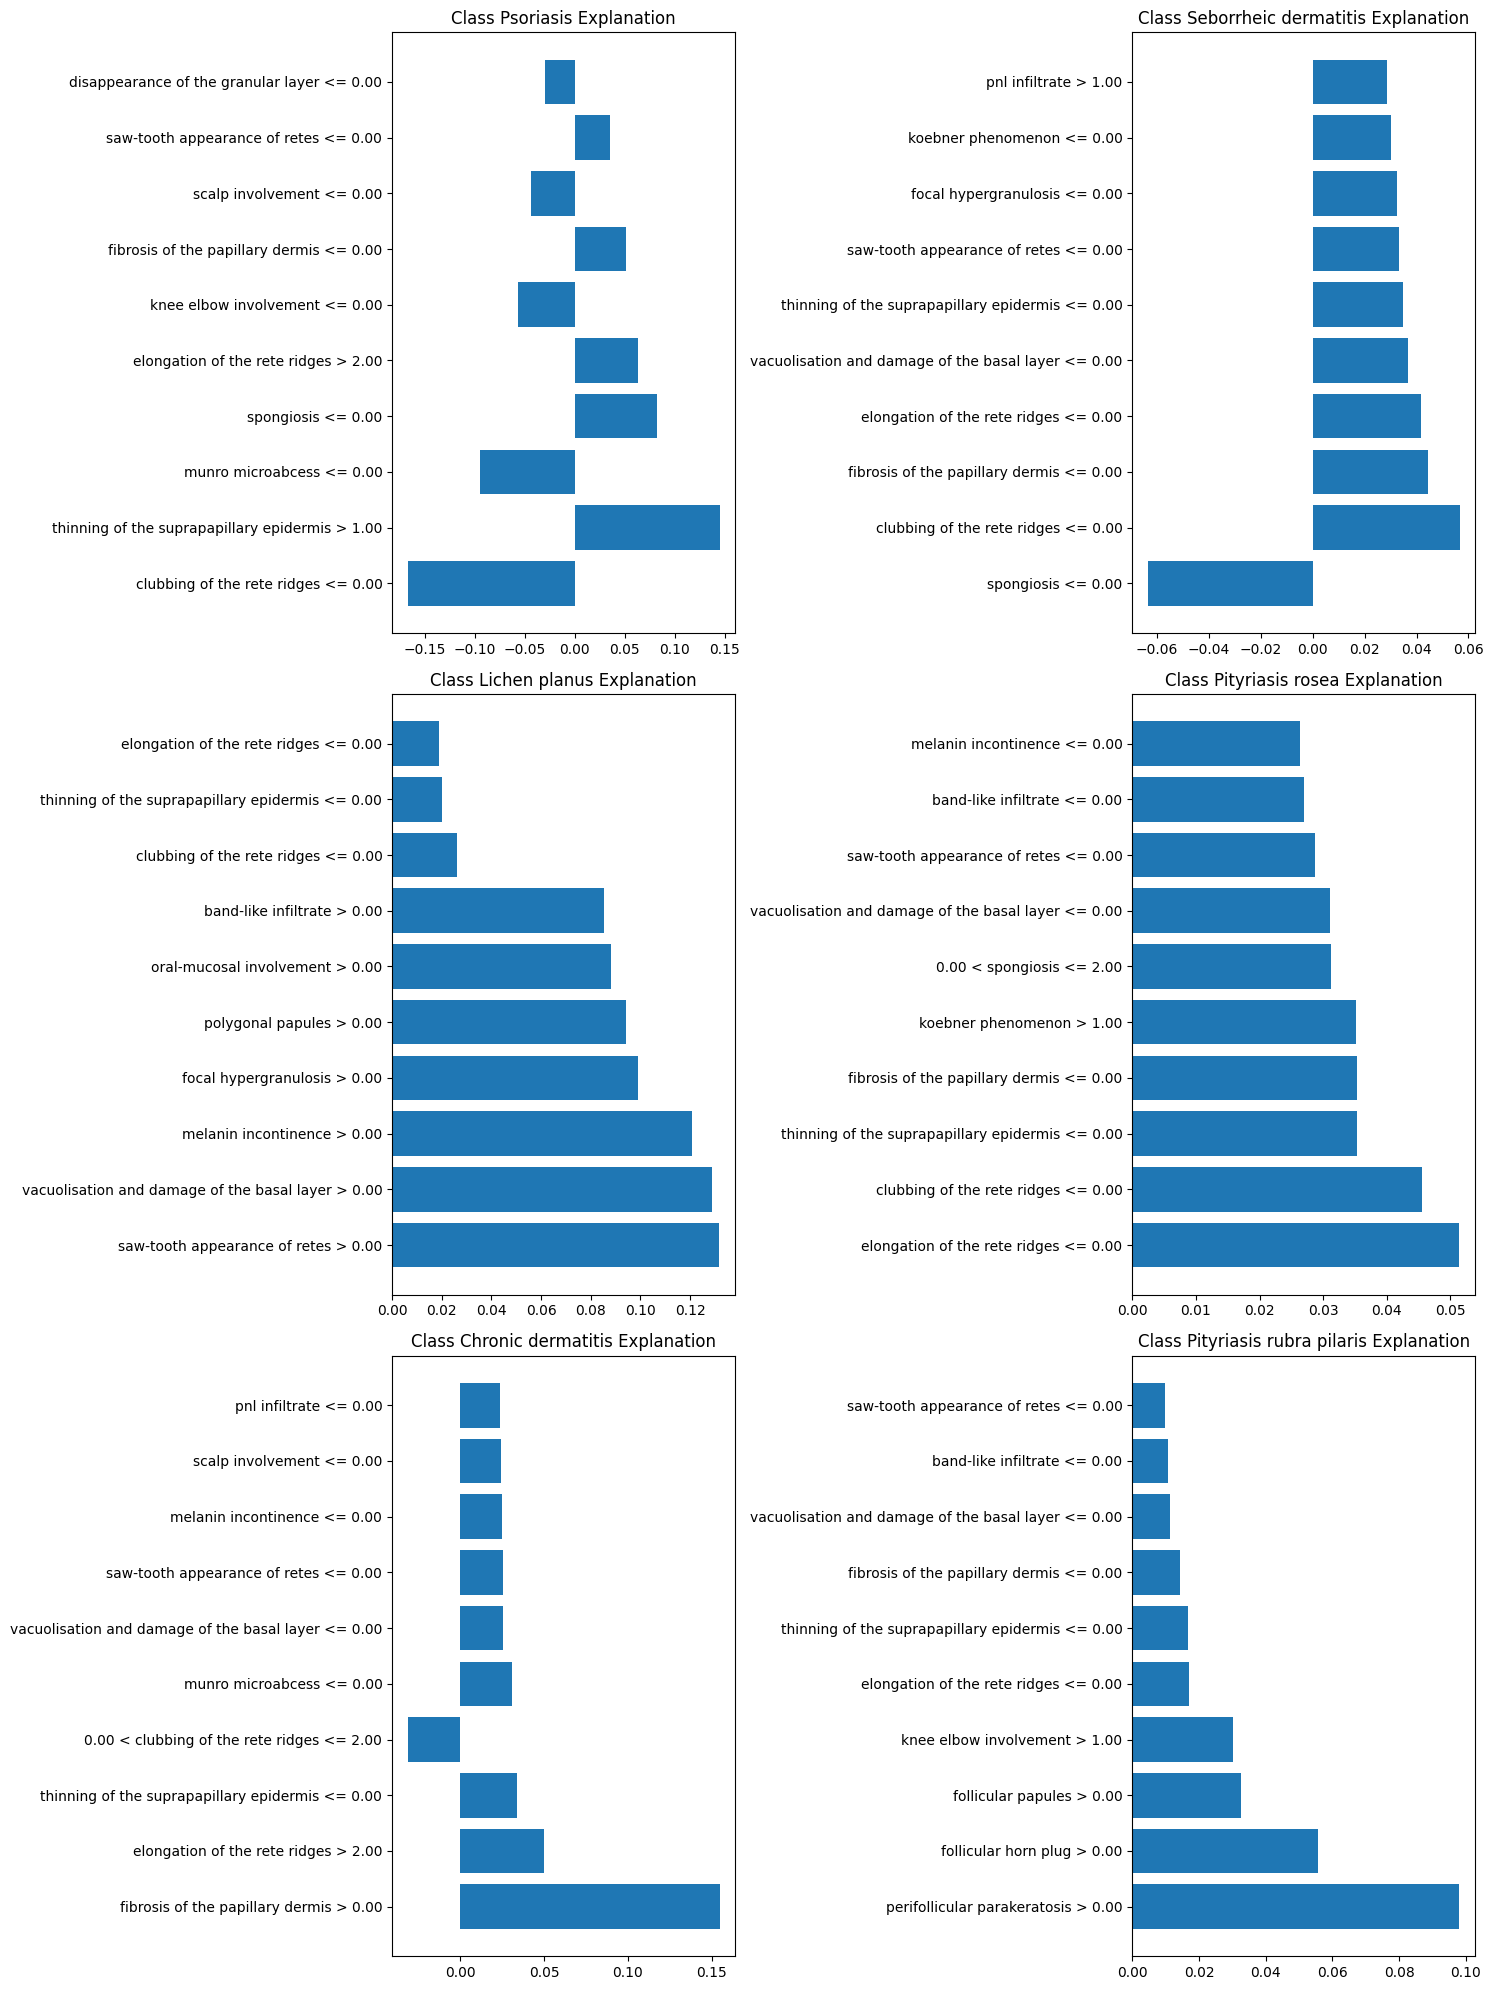

<Figure size 640x480 with 0 Axes>

In [ ]:
# 1. Save the best Extra Trees model using pickle
best_et = Pipeline([
    ('model', ExtraTreesClassifier().set_params(**best_params['ExtraTrees']))
])
best_et.fit(X_train, y_train)

# Save the model
with open('best_extra_trees_model.pkl', 'wb') as f:
    pickle.dump(best_et, f)

# 2. Load the saved model
with open('best_extra_trees_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


# 3. Prepare LIME explainers
feature_names = X_train.columns.tolist()
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=[f'Class_{i}' for i in range(6)],
    verbose=False,
    mode='classification'
)

# 4. Create visualization figure
plt.figure(figsize=(20, 10))

# Create a grid for LIME explanations
fig, axes = plt.subplots(3, 2, figsize=(15, 20))  # Create figure and axes here
class_names = ['Psoriasis', 'Seborrheic dermatitis', 'Lichen planus', 'Pityriasis rosea',
               'Chronic dermatitis', 'Pityriasis rubra pilaris']

# Ensure we're working with numpy arrays
y_test_np = y_test.values if isinstance(y_test, (pd.Series, pd.DataFrame)) else y_test
X_test_np = X_test.values if isinstance(X_test, (pd.Series, pd.DataFrame)) else X_test

for class_idx in range(6):
    # Find indices for current class
    class_indices = np.where(y_test_np == class_idx)[0]

    if len(class_indices) == 0:
        print(f"Skipping class {class_idx} - no samples in test set")
        continue

    # Get first sample for the class
    sample_idx = class_indices[0]

    # Get explanation
    exp = explainer_lime.explain_instance(
        X_test_np[sample_idx],
        loaded_model.predict_proba,
        num_features=10,
        top_labels=1
    )

    # Plot in grid
    row = class_idx // 2
    col = class_idx % 2

    # Get the explanation as a list
    exp_list = exp.as_list(label=class_idx)

    # Create the LIME plot using the list and the specific subplot axis
    axes[row, col].barh([x[0] for x in exp_list], [x[1] for x in exp_list])
    axes[row, col].set_title(f"Class {class_names[class_idx]} Explanation")

plt.tight_layout()
plt.show()
plt.savefig('lime_explanations.png')

## LIME Visualization Analysis
The LIME visualizations provide critical insights into feature contributions for six different skin conditions. These visualizations reveal distinct histopathological signatures for each condition, highlighting which features most strongly influence the model's classification decisions.

## Condition-Specific Feature Contributions
- ## Psoriasis
  The visualization for psoriasis shows "thinning of the suprapapillary epidermis > 1.00" as the most significant positive contributor to classification, with a substantial rightward bar. "Spongiosis" and "fibrosis of the papillary dermis" also appear as important positive features. Interestingly, "clubbing of the rete ridges <= 0.00" has a strong negative influence, indicating its absence supports the psoriasis diagnosis. These findings align with psoriasis' clinical presentation, where epidermal thinning over dermal papillae is a characteristic histopathological feature.

- ## Seborrheic Dermatitis
For seborrheic dermatitis, "spongiosis <= 0.00" and "clubbing of the rete ridges <= 0.00" contribute most positively to the classification, followed by "fibrosis of the papillary dermis" and "Koebner phenomenon." The distribution of feature importance is more evenly spread compared to other conditions, suggesting that seborrheic dermatitis diagnosis relies on a combination of several moderately important features rather than one or two dominant ones.

- ## Lichen Planus
The lichen planus visualization shows "vacuolisation and damage of the basal layer > 0.00" as the most influential feature, which aligns with the condition's known pathophysiology. Other key positive contributors include "saw-tooth appearance of rete ridges," "melanin incontinence," and "polygonal papules." The strong influence of these features reflects lichen planus' characteristic interface dermatitis with basal cell damage and pigment incontinence.

- ## Pityriasis Rosea
For pityriasis rosea, "elongation of the rete ridges <= 0.00" provides the strongest positive contribution, followed by "Koebner phenomenon > 1.00" and "clubbing of the rete ridges <= 0.00." The visualization indicates that the absence of certain features (like granular layer disappearance) is as important as the presence of others in diagnosing this condition.

- ## Chronic Dermatitis
The chronic dermatitis visualization is particularly notable for the dominant contribution of "fibrosis of the papillary dermis > 0.00," which is significantly stronger than any other feature. This aligns with chronic inflammation leading to dermal fibrosis as a hallmark of long-standing dermatitis. Other features such as "elongation of the rete ridges > 2.00" provide additional positive contributions, while minimal spongiosis has a negative impact.

- ## Pityriasis Rubra Pilaris
The pityriasis rubra pilaris graph emphasizes follicular features, with "perifollicular parakeratosis > 0.00" and "follicular horn plug > 0.00" as the strongest positive contributors. This accurately reflects the follicular-centric nature of this disorder, distinguishing it from other inflammatory dermatoses in the dataset.

## Cross-Condition Feature Analysis
The LIME visualizations reveal important patterns across conditions. Some features, such as "fibrosis of the papillary dermis," appear across multiple conditions but with varying importance and directional influence. For example, its presence strongly indicates chronic dermatitis, while its absence supports diagnoses of psoriasis and seborrheic dermatitis.

Similarly, "thinning of the suprapapillary epidermis" is a positive predictor for psoriasis but a negative predictor for lichen planus. The "clubbing of the rete ridges" feature shows interesting bidirectional influence across conditions—its absence supports some diagnoses while opposing others.




## SHAP Interpretation

In [ ]:
# 2. Load saved model
with open('best_extra_trees_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

tree_model = loaded_model.named_steps['model']

#Get shap values
explainer = shap.Explainer(tree_model)
shap_values_cat= explainer(X_train)

print(np.shape(shap_values_cat))


(292, 34, 6)


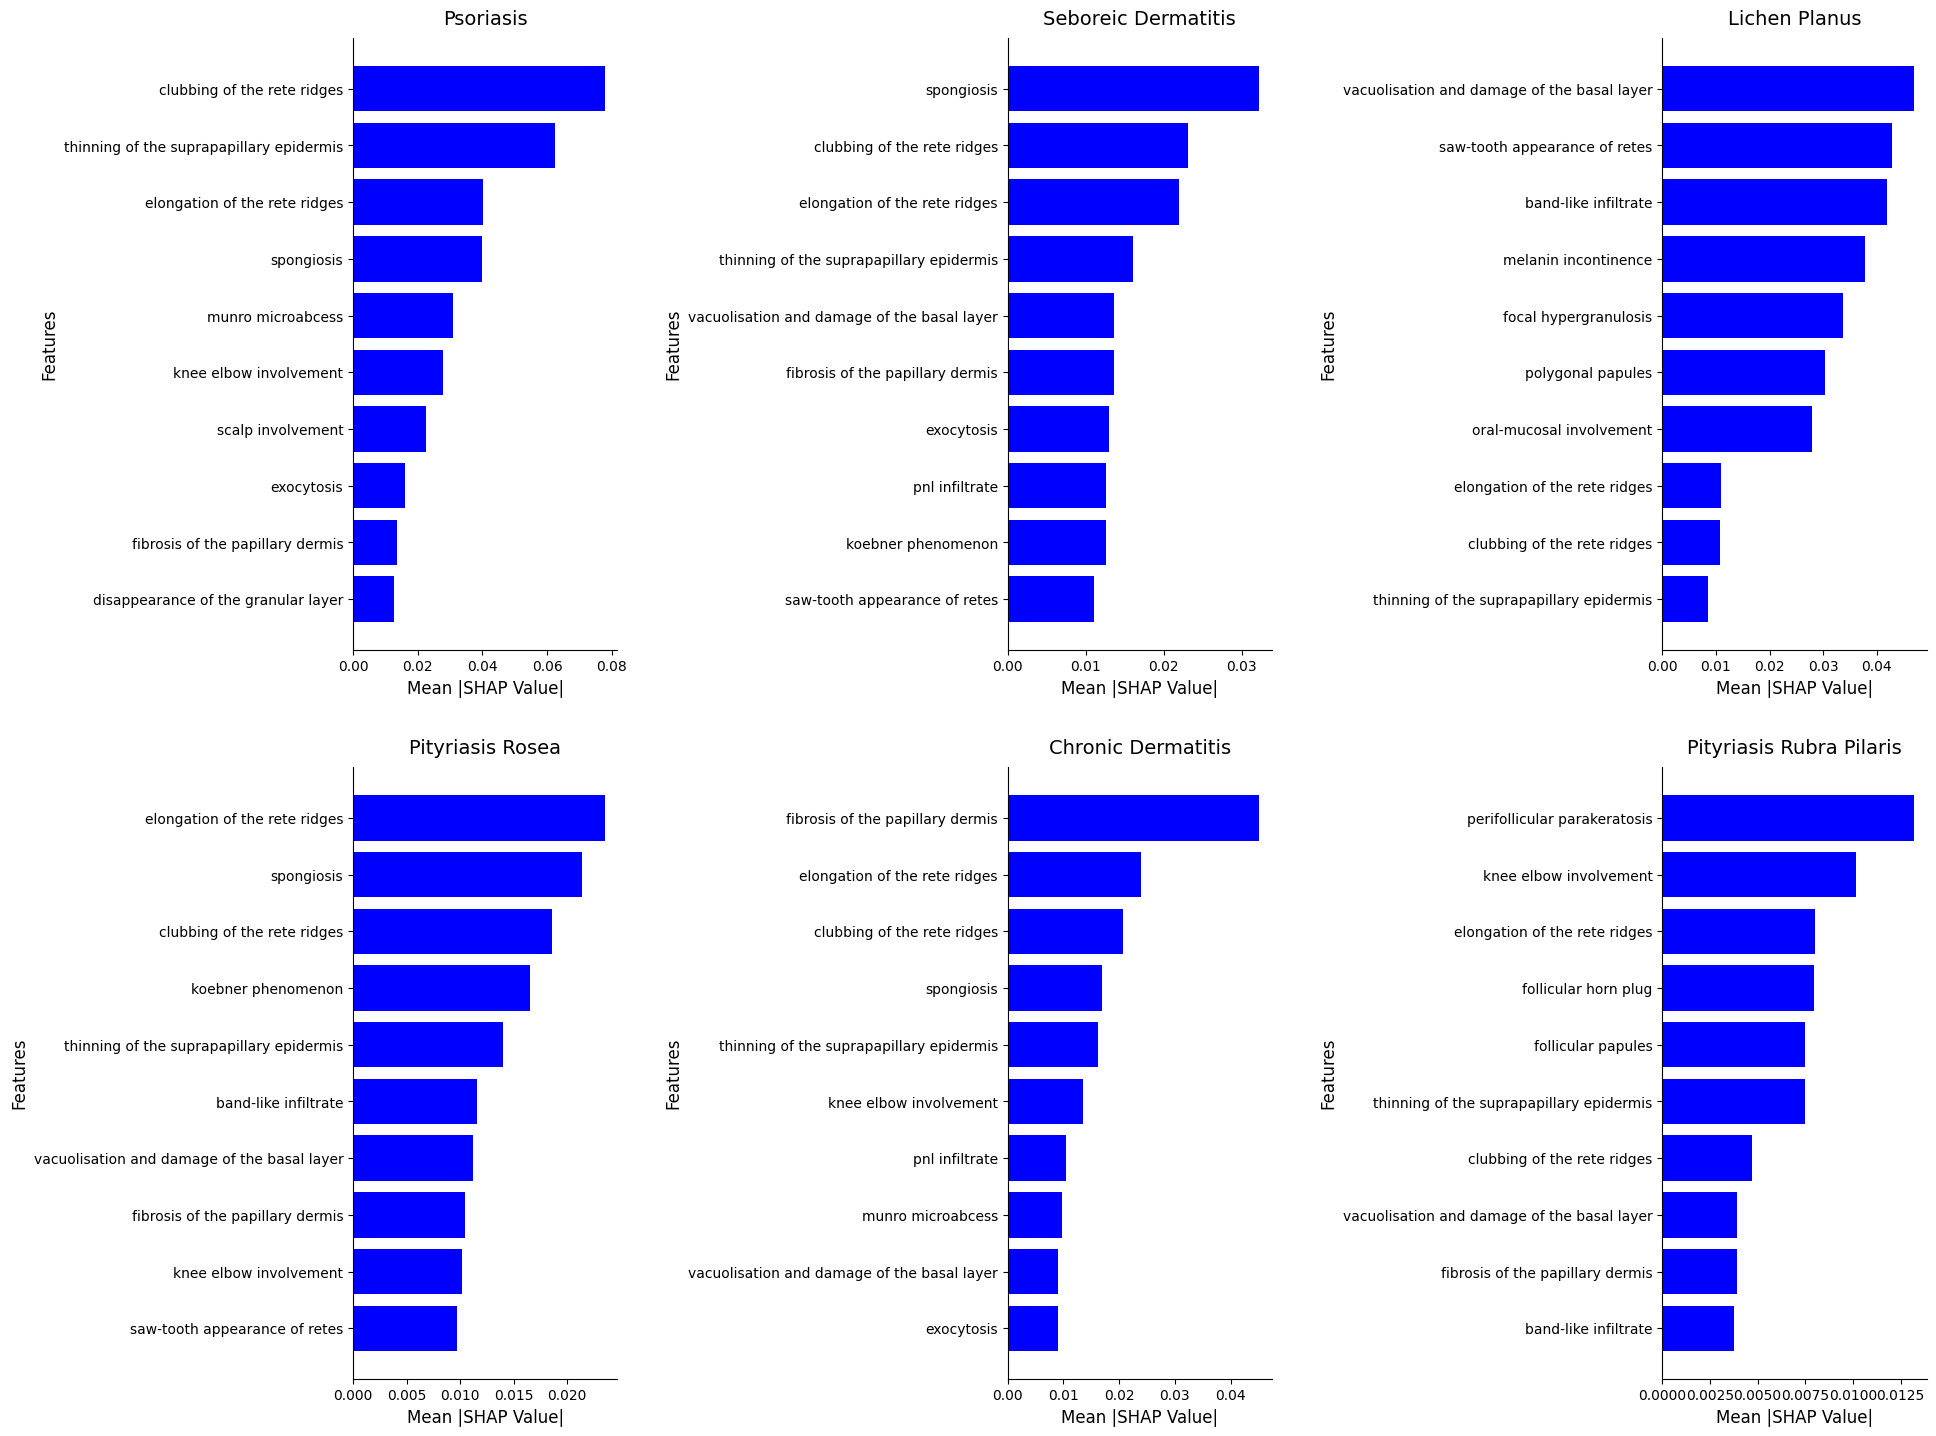

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Class names for dermatology dataset
class_names = [
    "Psoriasis",
    "Seboreic Dermatitis",
    "Lichen Planus",
    "Pityriasis Rosea",
    "Chronic Dermatitis",
    "Pityriasis Rubra Pilaris"
]

# Create Tree SHAP explainer
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_test)

# Create figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
axes = axes.flatten()

# Plot SHAP summary for each class
for i, class_name in enumerate(class_names):
    # Select SHAP values for current class
    shap_values_class = shap_values[i]

    # Calculate mean absolute SHAP values
    mean_shap = np.abs(shap_values_class).mean(axis=0)

    # Sort features by importance
    sorted_idx = np.argsort(mean_shap)[-10:]  # Top 10 features
    sorted_vals = mean_shap[sorted_idx]
    sorted_names = [X_test.columns[j] for j in sorted_idx]

    # Create horizontal bar plot
    ax = axes[i]
    ax.barh(range(10), sorted_vals, align='center', color='blue')
    ax.set_yticks(range(10))
    ax.set_yticklabels(sorted_names, fontsize=10)
    ax.set_title(f"{class_name}", fontsize=14, pad=10)
    ax.set_xlabel("Mean |SHAP Value|", fontsize=12)
    ax.set_ylabel("Features", fontsize=12)
    ax.tick_params(axis='x', labelsize=10)

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout(pad=3.0)

# Save and display
plt.savefig('dermatology_shap_summary_grid.png', dpi=300, bbox_inches='tight')
plt.show()

# SHAP Analysis of Feature Importance

The SHAP (SHapley Additive exPlanations) figure provides a detailed breakdown of feature importance across six dermatological conditions. SHAP values quantify the magnitude and direction of each feature's impact on the classification outcomes.

* ## Psoriasis
  The SHAP analysis for psoriasis identifies "clubbing of the rete ridges" as the most influential feature, with a high positive SHAP value indicating its strong contribution to psoriasis classification. "Thinning of the suprapapillary epidermis" and "spongiosis" also emerge as significant contributors, reflecting important histopathological characteristics of psoriasis. Other features like "elongation of the rete ridges" and "fibrosis of the papillary dermis" play a secondary role but still provide meaningful contributions. The prominence of these features aligns with clinical findings, where epidermal changes and dermal inflammation are central to psoriasis pathology.

* ## Seborrheic Dermatitis
  For seborrheic dermatitis, "spongiosis" is the most critical feature, followed closely by "clubbing of the rete ridges" and "Koebner phenomenon." These features collectively capture the inflammatory and structural changes characteristic of seborrheic dermatitis. The SHAP values for features like "fibrosis of the papillary dermis" and "thinning of the suprapapillary epidermis" are lower but still positive, suggesting their supportive role in classification. The visualization highlights how seborrheic dermatitis relies on a combination of epidermal and dermal features for accurate diagnosis.

* ## Lichen Planus
The SHAP graph for lichen planus underscores "vacuolisation and damage of the basal layer" as the dominant feature, consistent with its known pathophysiology involving basal cell degeneration. Other significant contributors include "band-like infiltrate," "saw-tooth appearance of rete ridges," and "polygonal papules," which are hallmark features of lichen planus. Interestingly, features like "melanin incontinence" and "focal hypergranulosis" also show moderate positive contributions, reflecting pigmentary changes and granular layer alterations typical of this condition.

* ## Pityriasis Rosea
For pityriasis rosea, "elongation of the rete ridges" emerges as the most influential feature, followed by "Koebner phenomenon" and "spongiosis." The absence or minimal presence of certain features, such as granular layer disappearance, contributes negatively to classification, highlighting their diagnostic relevance. The SHAP values indicate that pityriasis rosea relies on a distinct set of epidermal features for differentiation from other conditions.

* ## Chronic Dermatitis
  The SHAP analysis for chronic dermatitis reveals "fibrosis of the papillary dermis" as overwhelmingly dominant, with a significantly higher SHAP value compared to other features. This aligns with chronic inflammation leading to dermal fibrosis as a defining characteristic. Secondary contributors include "elongation of the rete ridges" and "spongiosis," which reflect ongoing epidermal changes associated with chronic dermatitis. The visualization demonstrates how fibrosis serves as a cornerstone for distinguishing chronic dermatitis from other inflammatory skin conditions.

* ## Pityriasis Rubra Pilaris
  For pityriasis rubra pilaris, follicular-centric features dominate the SHAP analysis. "Perifollicular parakeratosis" is identified as the most critical feature, followed by "follicular papules" and "knee elbow involvement." These findings align with pityriasis rubra pilaris' clinical presentation involving follicular hyperkeratosis and characteristic papules. Secondary contributors such as "follicular horn plug" reflect additional follicular changes that aid in classification.

# Cross-Condition Feature Patterns

The SHAP visualizations reveal several cross-condition patterns in feature importance. For example, while "fibrosis of the papillary dermis" is critical for chronic dermatitis classification, it plays a less significant role in other conditions like psoriasis or seborrheic dermatitis. Similarly, features like "clubbing of the rete ridges" show variable importance across conditions—being highly influential for psoriasis but less so for pityriasis rubra pilaris.

Certain features exhibit bidirectional influence depending on the condition. For instance, "thinning of the suprapapillary epidermis" contributes positively to psoriasis classification but negatively to lichen planus diagnosis. This variability underscores how individual features interact differently within distinct pathological contexts.



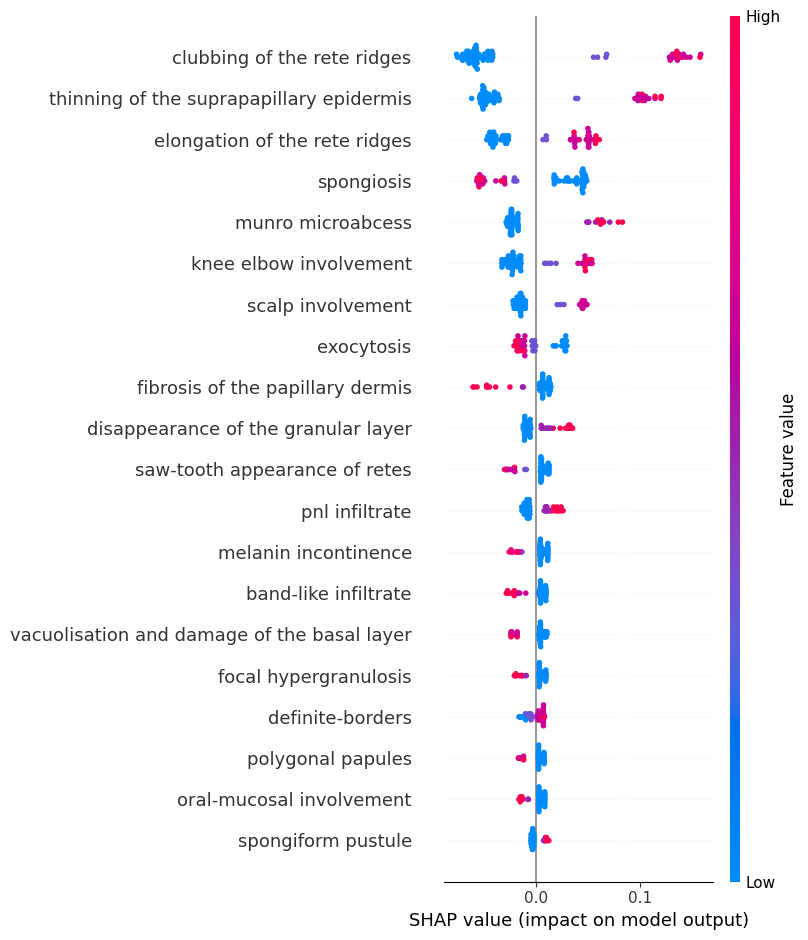

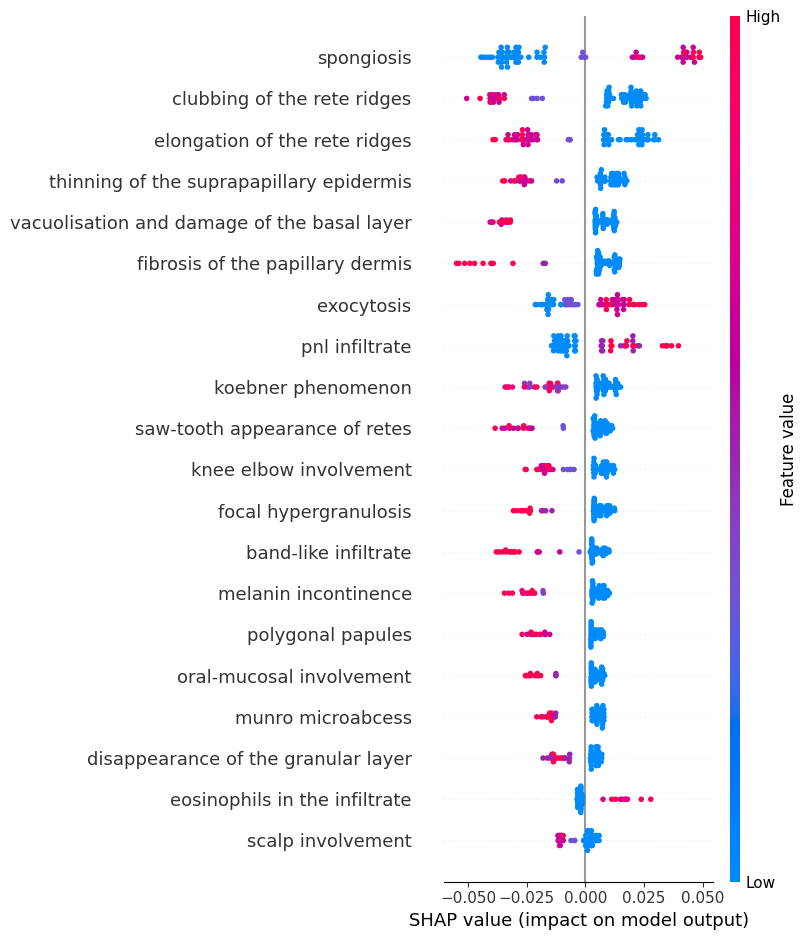

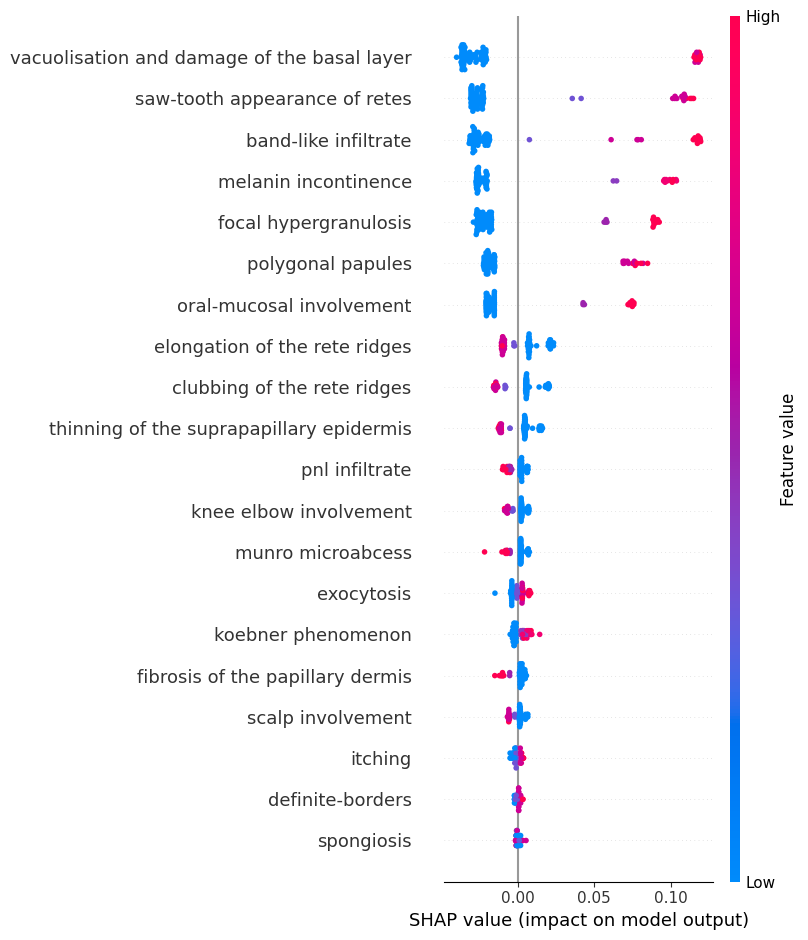

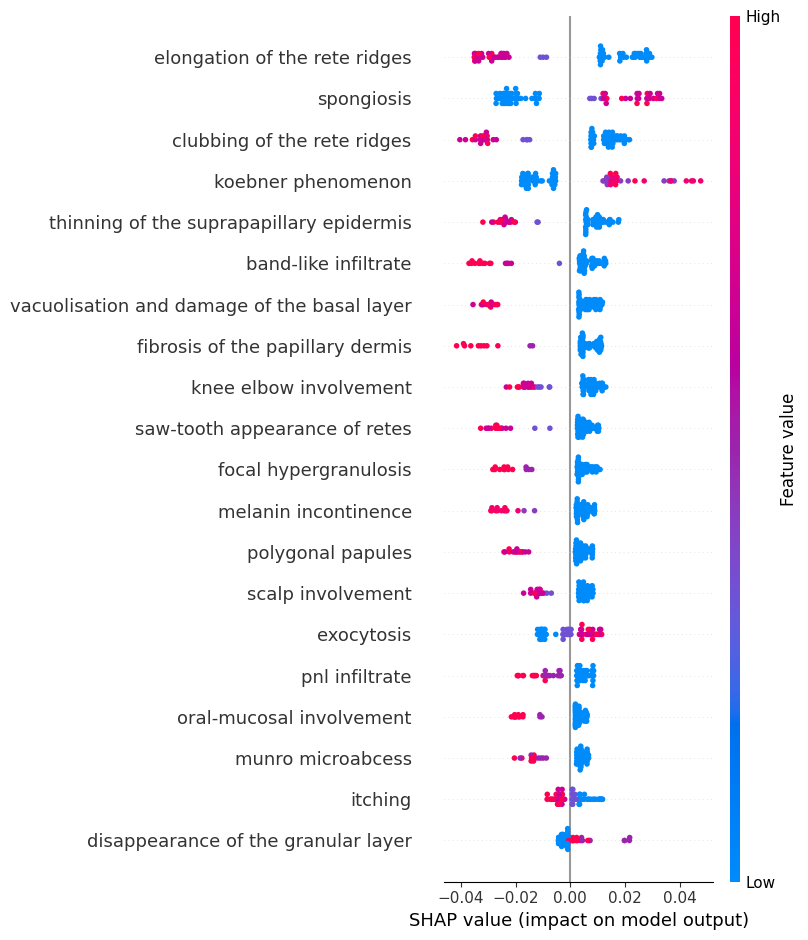

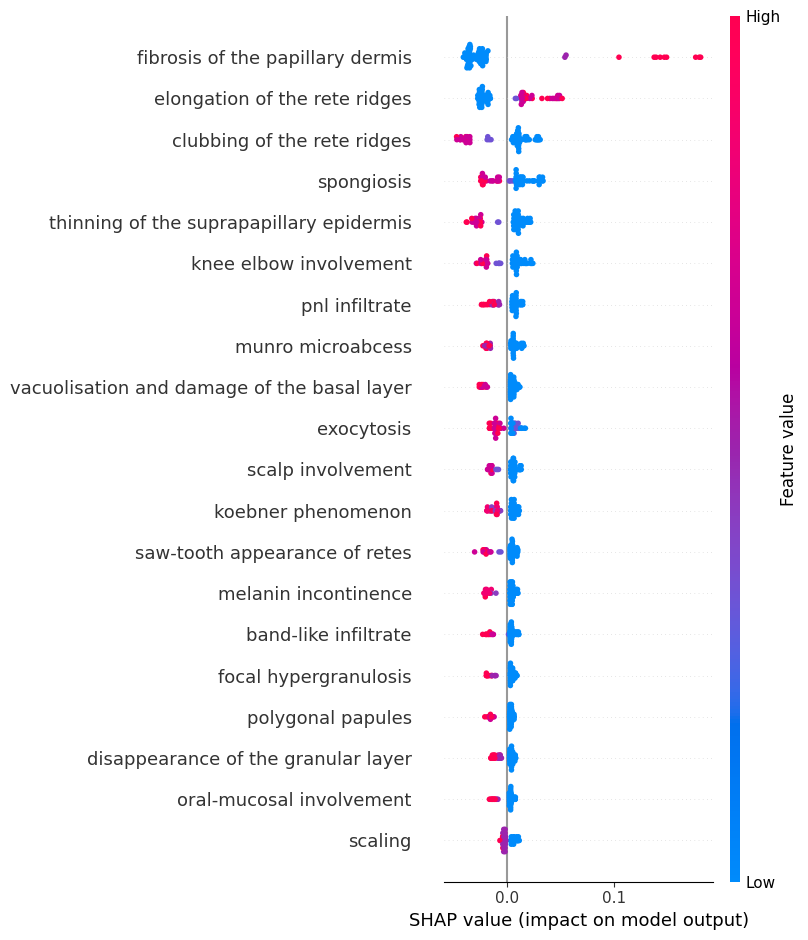

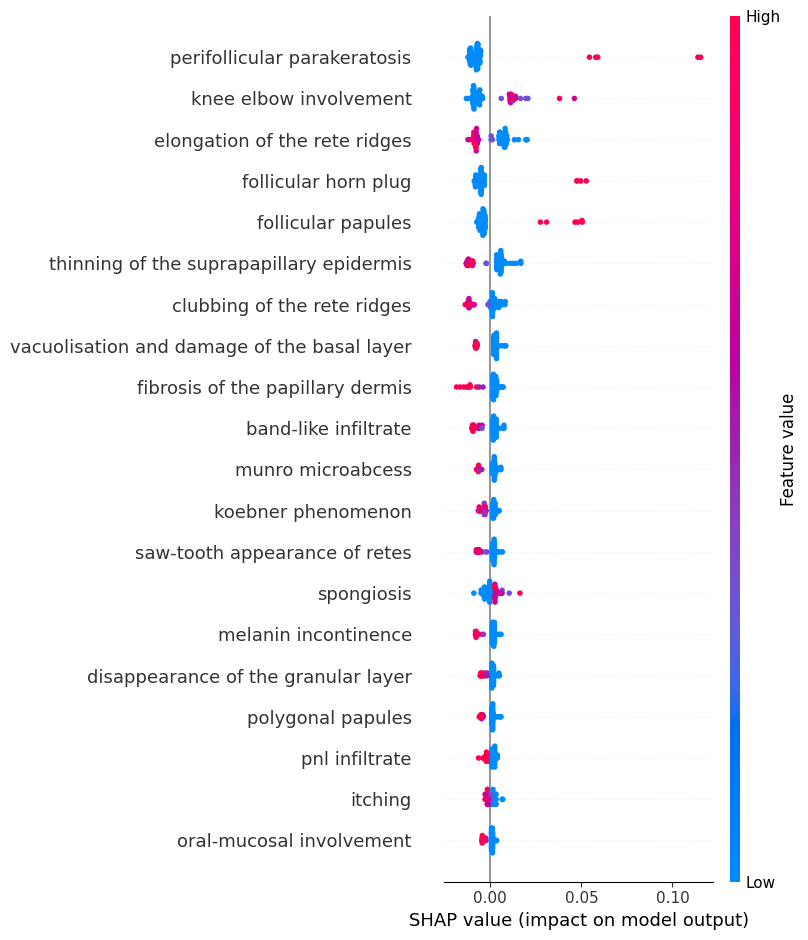

<Figure size 640x480 with 0 Axes>

In [ ]:
# Class names for dermatology dataset
class_names = [
    "Psoriasis",
    "Seboreic Dermatitis",
    "Lichen Planus",
    "Pityriasis Rosea",
    "Chronic Dermatitis",
    "Pityriasis Rubra Pilaris"
]

# Create Tree SHAP explainer
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary for each class
for i, class_name in enumerate(class_names):
    # Select SHAP values for current class
    shap_values_class = shap_values[i]

    # Create summary plot in subplot
    shap.summary_plot(
        shap_values_class,
        X_test,
        title=class_name
    )


# Save and display
plt.savefig('dermatology_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

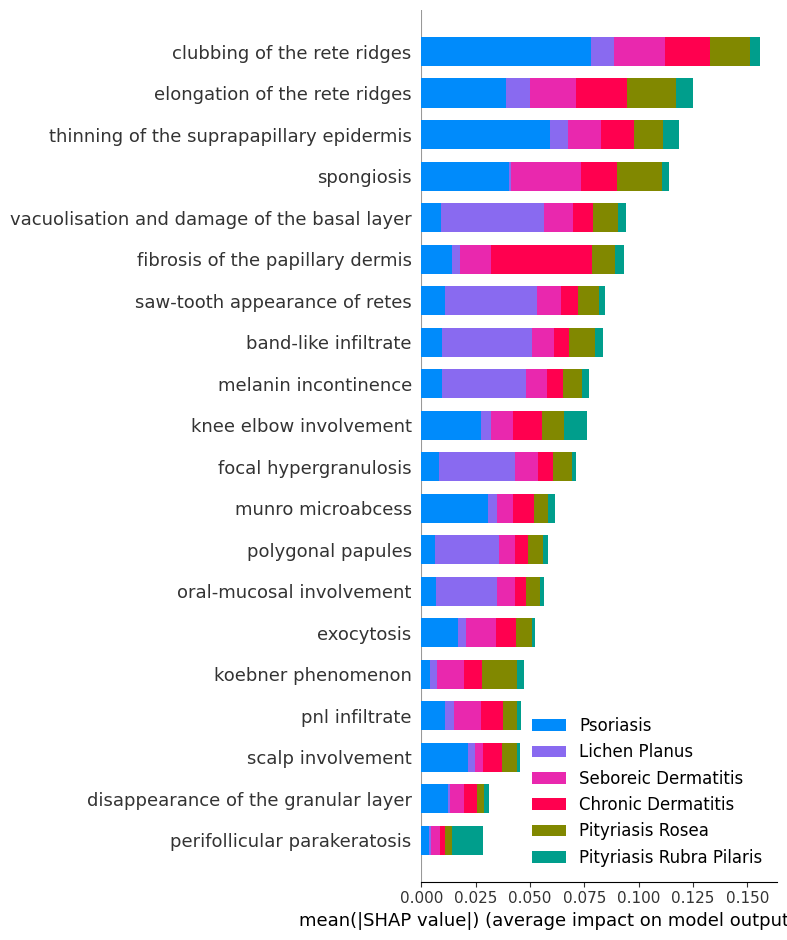

<Figure size 640x480 with 0 Axes>

In [ ]:


# Create the SHAP Explainer
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_train)

# Plot SHAP values for each class
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names= class_names)
plt.savefig('dermatology_shap_summary_bar.png', dpi=300, bbox_inches='tight')



# SHAP Bar Plot Analysis

The SHAP bar plot provides a comprehensive overview of feature importance across all classes. By aggregating the mean absolute SHAP values for each feature, the visualization highlights the average impact of individual histopathological features on model predictions across six dermatological conditions. This multi-class representation enables a comparative analysis of feature relevance across conditions, offering valuable insights into shared and unique diagnostic markers.

## Global Feature Importance Across Classes

* Dominant Features
  The most impactful features across all classes include "clubbing of the rete ridges," "spongiosis," "elongation of the rete ridges," "thinning of the suprapapillary epidermis," and "fibrosis of the papillary dermis." These features consistently exhibit high mean SHAP values, indicating their significant contributions to distinguishing between dermatological conditions.

- **Clubbing of the rete ridges** emerges as the most influential feature overall, with substantial contributions across multiple conditions. Its prominence reflects its diagnostic relevance in disorders like psoriasis and seborrheic dermatitis, where epidermal structural changes are critical.
  - **Spongiosis**, a marker of intercellular edema in the epidermis, ranks second in importance. It plays a vital role in inflammatory conditions such as seborrheic dermatitis and chronic dermatitis.
  - **Elongation of the rete ridges** is another key feature with widespread impact across classes. This structural alteration is particularly relevant in psoriasis and pityriasis rosea.
  - **Thinning of the suprapapillary epidermis** is highly specific to psoriasis but also contributes moderately to other conditions.
  - **Fibrosis of the papillary dermis** is predominantly associated with chronic dermatitis but shows moderate importance in other classes.

* Intermediate Features
  Features such as "vacuolisation and damage of the basal layer," "band-like infiltrate," "saw-tooth appearance of rete ridges," and "Koebner phenomenon" exhibit moderate SHAP values. These features are more condition-specific but still contribute significantly to model predictions.

  - **Vacuolisation and damage of the basal layer** is particularly critical for lichen planus, reflecting its pathophysiological hallmark.
  - **Band-like infiltrate** aligns with lichen planus' characteristic lymphocytic infiltration at the dermoepidermal junction.
  - **Saw-tooth appearance of rete ridges** is another distinctive feature for lichen planus, while **Koebner phenomenon** contributes to psoriasis and pityriasis rosea.

* Minor Features
  Features with lower mean SHAP values include "melanin incontinence," "polygonal papules," "itching," and "disappearance of the granular layer." Although less impactful overall, these features still play important roles in specific conditions:
  - **Melanin incontinence** is relevant for lichen planus due to basal cell damage leading to pigmentary changes.
  - **Polygonal papules** are unique to lichen planus and contribute moderately to its classification.
  - **Disappearance of the granular layer** has limited importance but aligns with pityriasis rubra pilaris' histopathological findings.

## Condition-Specific Insights

* Psoriasis
  Psoriasis relies heavily on features such as "clubbing of the rete ridges," "thinning of the suprapapillary epidermis," and "elongation of the rete ridges." These structural changes are hallmarks of psoriasis pathology and dominate its SHAP contributions.

### Seborrheic Dermatitis
Seborrheic dermatitis emphasizes inflammatory features like "spongiosis" and structural alterations such as "clubbing of the rete ridges." The moderate contribution of "fibrosis of the papillary dermis" reflects its chronic inflammatory nature.

### Chronic Dermatitis
Chronic dermatitis is uniquely characterized by high SHAP values for "fibrosis of the papillary dermis," underscoring its defining histopathological marker. Other contributors include "spongiosis" and "elongation of the rete ridges."

### Pityriasis Rosea
Pityriasis rosea exhibits moderate SHAP contributions from features like "elongation of the rete ridges" and "Koebner phenomenon." The absence or minimal presence of certain features also plays a role in classification.

### Lichen Planus
Lichen planus stands out for its reliance on features such as "vacuolisation and damage of the basal layer," "band-like infiltrate," and "saw-tooth appearance of rete ridges." These findings align with its interface dermatitis pathology.

### Pityriasis Rubra Pilaris
Pityriasis rubra pilaris emphasizes follicular-centric features like "perifollicular parakeratosis" and structural changes such as "follicular horn plug." These features are unique to its classification.

## Cross-Class Patterns

The SHAP bar plot reveals shared importance among certain features (e.g., clubbing of the rete ridges, spongiosis) that contribute across multiple conditions. This suggests that while these features are broadly relevant, their specific thresholds or combinations may differentiate one condition from another. Conversely, highly condition-specific features like "vacuolisation and damage of the basal layer" or "perifollicular parakeratosis" highlight unique diagnostic markers for individual disorders.

## Clinical Implications

This SHAP analysis enhances interpretability by quantifying feature importance across all classes simultaneously. By identifying globally dominant features (e.g., clubbing of rete ridges) alongside condition-specific markers (e.g., vacuolisation for lichen planus), clinicians can better understand how machine learning models arrive at their predictions.